In [18]:
# Listing all the fields
from mp_api.client import MPRester
from secretInfo import APIKEY

with MPRester(APIKEY) as mpr:
    fields = mpr.materials.summary.available_fields
    print(fields)

['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'bulk_modulus', 'shear_modulus', 'universal_anisotropy', 'homogeneous_poisson', 'e_total', 'e_ionic', 'e_electronic',

In [19]:
from mp_api.client import MPRester
import pandas as pd
from secretInfo import APIKEY  # your API key module

# Define the fields to pull
fields = [
    "material_id",
    "formula_pretty",
    "elements",
    "nelements",
    "band_gap",
    "density",
    "formation_energy_per_atom",
    "energy_above_hull",
    "bulk_modulus",
    "shear_modulus",
    "volume",
    "nsites",
    "total_magnetization",
    "structure"
]


# Connect to the Materials Project API
with MPRester(APIKEY) as mpr:
    docs = mpr.materials.summary.search(
        fields=fields,
        num_chunks=100  # pull more than one page of results
    )

# Convert to dictionary list for DataFrame creation
materials_data = [
    {
        "material_id": d.material_id,
        "formula": d.formula_pretty,
        "elements": d.elements,
        "nelements": d.nelements,
        "band_gap": d.band_gap,
        "formation_energy_per_atom": d.formation_energy_per_atom,
        "bulk_modulus": getattr(d, "bulk_modulus", None),
        "shear_modulus": getattr(d, "shear_modulus", None),
        "density": d.density,
        "energy_above_hull": d.energy_above_hull,
        "volume": d.volume,
        "nsites": d.nsites,
        "total_magnetization": getattr(d, "total_magnetization", None)
    }
    for d in docs
]


# Load into a DataFrame
df = pd.DataFrame(materials_data)

Retrieving SummaryDoc documents: 100%|██████████| 100000/100000 [01:32<00:00, 1082.87it/s]


In [20]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

def extract_modulus_value(x):
    """Extract modulus value in order: voigt → vrh → reuss."""
    if isinstance(x, dict):
        return x.get('voigt') or x.get('vrh') or x.get('reuss')
    return np.nan  # Ensures missing values are caught

def clean_and_impute_material_data(df, use_knn=True):
    # ---- Step 1: Extract numeric values from complex modulus fields ----
    df['shear_modulus_final'] = df['shear_modulus'].apply(extract_modulus_value)
    df['bulk_modulus_final'] = df['bulk_modulus'].apply(extract_modulus_value)

    # ---- Step 2: Define all required features for modeling ----
    required_features = [
        'band_gap',
        'formation_energy_per_atom',
        'bulk_modulus_final',
        'shear_modulus_final',
        'density',
        'volume',
        'total_magnetization',
        'energy_above_hull',
        'nsites'
    ]

    # ---- Step 3: Check missing values before cleaning ----
    print("\nMissing values BEFORE cleaning:")
    print(df[required_features].isnull().sum())

    if use_knn:
        # ---- Step 4a: KNN Imputation ----
        knn_imputer = KNNImputer(n_neighbors=5)
        imputed_array = knn_imputer.fit_transform(df[required_features])
        df[required_features] = pd.DataFrame(imputed_array, columns=required_features, index=df.index)
        print("\nKNN Imputation applied.")
    else:
        # ---- Step 4b: Strict Cleaning (Drop rows with missing values) ----
        df = df.dropna(subset=required_features)
        print("\nRows dropped with missing critical values.")

    # ---- Step 5: Report missing values after cleaning/imputation ----
    print("\nMissing values AFTER cleaning/imputation:")
    print(df[required_features].isnull().sum())

    # ---- Optional: Drop original complex columns ----
    df = df.drop(columns=['bulk_modulus', 'shear_modulus'], errors='ignore')

    return df


In [21]:
knn_features = [
    'energy_above_hull', 'total_magnetization',
    'shear_modulus_final', 'bulk_modulus_final'
]

df_cleaned = clean_and_impute_material_data(df, use_knn=False)


Missing values BEFORE cleaning:
band_gap                         0
formation_energy_per_atom        0
bulk_modulus_final           87358
shear_modulus_final          87358
density                          0
volume                           0
total_magnetization              0
energy_above_hull                0
nsites                           0
dtype: int64

Rows dropped with missing critical values.

Missing values AFTER cleaning/imputation:
band_gap                     0
formation_energy_per_atom    0
bulk_modulus_final           0
shear_modulus_final          0
density                      0
volume                       0
total_magnetization          0
energy_above_hull            0
nsites                       0
dtype: int64


In [22]:
print(df_cleaned)

      material_id    formula          elements  nelements  band_gap  \
1      mp-1120447         Si              [Si]          1    0.0000   
32      mp-644693         Si              [Si]          1    0.0000   
50          mp-42         Ta              [Ta]          1    0.0000   
51     mp-1009490         O2               [O]          1    1.4260   
63       mp-12957         O2               [O]          1    1.0933   
...           ...        ...               ...        ...       ...   
99804   mp-974307    NdCuTeO   [Cu, Nd, O, Te]          4    1.4760   
99805   mp-975646    PrZnSbO   [O, Pr, Sb, Zn]          4    0.1208   
99806   mp-983603    ErZnAsO   [As, Er, O, Zn]          4    1.1517   
99807     mp-9929   ZrCuSiAs  [As, Cu, Si, Zr]          4    0.0000   
99808  mp-1019584  CaAl2SiO6   [Al, Ca, O, Si]          4    4.6057   

       formation_energy_per_atom    density  energy_above_hull      volume  \
1                       0.372510   2.288020           0.372510  163.0

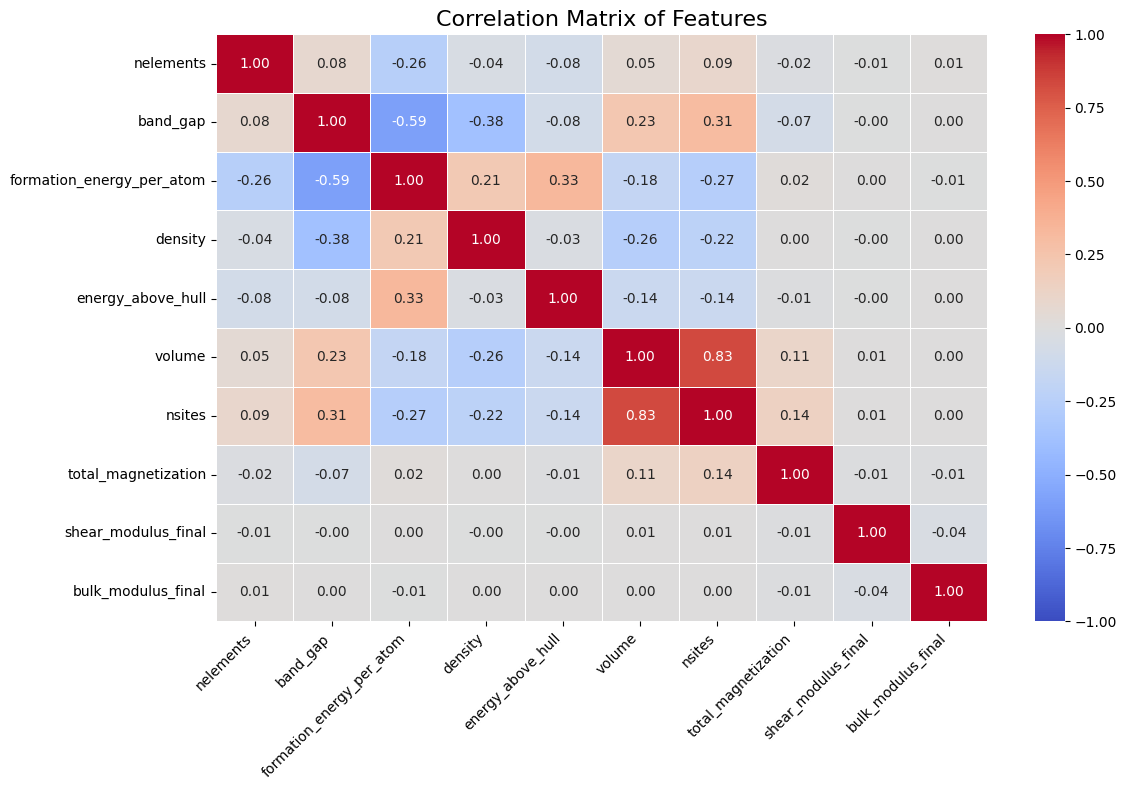

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, features=None):
    """Plot correlation matrix for the given features."""
    # If specific features are provided, filter the DataFrame
    if features:
        df = df[features]

    # Exclude non-numeric columns
    df_numeric = df.select_dtypes(include='number')

    # Calculate the correlation matrix
    corr_matrix = df_numeric.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))
    
    # Generate a heatmap of the correlation matrix
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

    # Set title and labels
    plt.title('Correlation Matrix of Features', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show the plot
    plt.show()

# Usage example
# Plot correlation matrix for all features in the cleaned DataFrame
plot_correlation_matrix(df_cleaned)

In [24]:
from mp_api.client import MPRester
from secretInfo import APIKEY

with MPRester(APIKEY) as mpr:
  ex_d = mpr.get_structure_by_material_id("mp-149")
  print(ex_d.lattice.abc)
  print(ex_d.lattice.angles)


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 25731.93it/s]

(3.8492784033699095, 3.8492794116013456, 3.849278)
(60.00001213094421, 60.00000346645984, 60.00001097545789)


In [25]:
from mp_api.client import MPRester

def add_lattice_constants(df):
    a_vals, b_vals, c_vals = [], [], []
    alpha_vals, beta_vals, gamma_vals = [], [], []

    with MPRester(APIKEY) as mpr:
        for mpid in df['material_id']:
            try:
                struct = mpr.get_structure_by_material_id(mpid)
                a, b, c = struct.lattice.abc
                alpha, beta, gamma = struct.lattice.angles
                a_vals.append(a)
                b_vals.append(b)
                c_vals.append(c)
                alpha_vals.append(alpha)
                beta_vals.append(beta)
                gamma_vals.append(gamma)
            except Exception as e:
                print(f"Error retrieving lattice data for {mpid}: {e}")
                a_vals.append(None)
                b_vals.append(None)
                c_vals.append(None)
                alpha_vals.append(None)
                beta_vals.append(None)
                gamma_vals.append(None)

    df['lattice_a'] = a_vals
    df['lattice_b'] = b_vals
    df['lattice_c'] = c_vals
    df['lattice_alpha'] = alpha_vals
    df['lattice_beta'] = beta_vals
    df['lattice_gamma'] = gamma_vals

    return df

df_with_lattice = add_lattice_constants(df_cleaned)


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 43240.25it/s]


In [ ]:
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

final_df = df_with_lattice
target_columns = ["lattice_a", "lattice_b", "lattice_c", "lattice_alpha", "lattice_beta", "lattice_gamma"]

X = final_df.drop(columns=target_columns + ['material_id'] + ['formula'] + ['elements'])
Y = final_df[target_columns]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X.columns)

(9692, 10) (9692, 6)
(2423, 10) (2423, 6)
Index(['nelements', 'band_gap', 'formation_energy_per_atom', 'density',
       'energy_above_hull', 'volume', 'nsites', 'total_magnetization',
       'shear_modulus_final', 'bulk_modulus_final'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit only on training data
X_test_scaled = scaler.transform(X_test)        # apply same transform to test data

In [78]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

# Optionally evaluate
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 212.01232756418995


In [79]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate_multioutput_regression(y_true, y_pred, target_names=None):
    n_targets = y_true.shape[1]
    print("Performance Metrics per Output:\n")
    
    for i in range(n_targets):
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        
        name = target_names[i] if target_names else f"Target {i+1}"
        print(f"{name}:")
        print(f"  R²   = {r2:.3f}")
        print(f"  MAE  = {mae:.3f}")
        print(f"  MSE  = {mse:.3f}\n")


def plot_multioutput_regression_results(y_true, y_pred, target_names=None):
    n_targets = y_true.shape[1]
    fig, axs = plt.subplots(2, int(np.ceil(n_targets / 2)), figsize=(15, 8))
    axs = axs.flatten()

    for i in range(n_targets):
        axs[i].scatter(y_true[:, i], y_pred[:, i], alpha=0.6, color='steelblue', edgecolors='k')
        axs[i].plot([y_true[:, i].min(), y_true[:, i].max()],
                    [y_true[:, i].min(), y_true[:, i].max()],
                    'r--', lw=2)
        name = target_names[i] if target_names else f"Target {i+1}"
        axs[i].set_title(f"{name} - Predicted vs Actual")
        axs[i].set_xlabel("Actual")
        axs[i].set_ylabel("Predicted")

    plt.tight_layout()
    plt.show()


/Users/mylesgrant/CrystalClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Performance Metrics per Output:

lattice_a:
  R²   = -426886734665.132
  MAE  = 21826.806
  MSE  = 676269331390.942

lattice_b:
  R²   = -107250910356.227
  MAE  = 12453.715
  MSE  = 189051542625.097

lattice_c:
  R²   = -600373800954.495
  MAE  = 42278.808
  MSE  = 2420093590782.911

lattice_alpha:
  R²   = -10417223573199.057
  MAE  = 1693322.197
  MSE  = 4321029384124244.500

lattice_beta:
  R²   = -9976158083010.393
  MAE  = 1638456.375
  MSE  = 4041469439286759.500

lattice_gamma:
  R²   = -3548504682872.065
  MAE  = 1173237.338
  MSE  = 2015145328520898.500



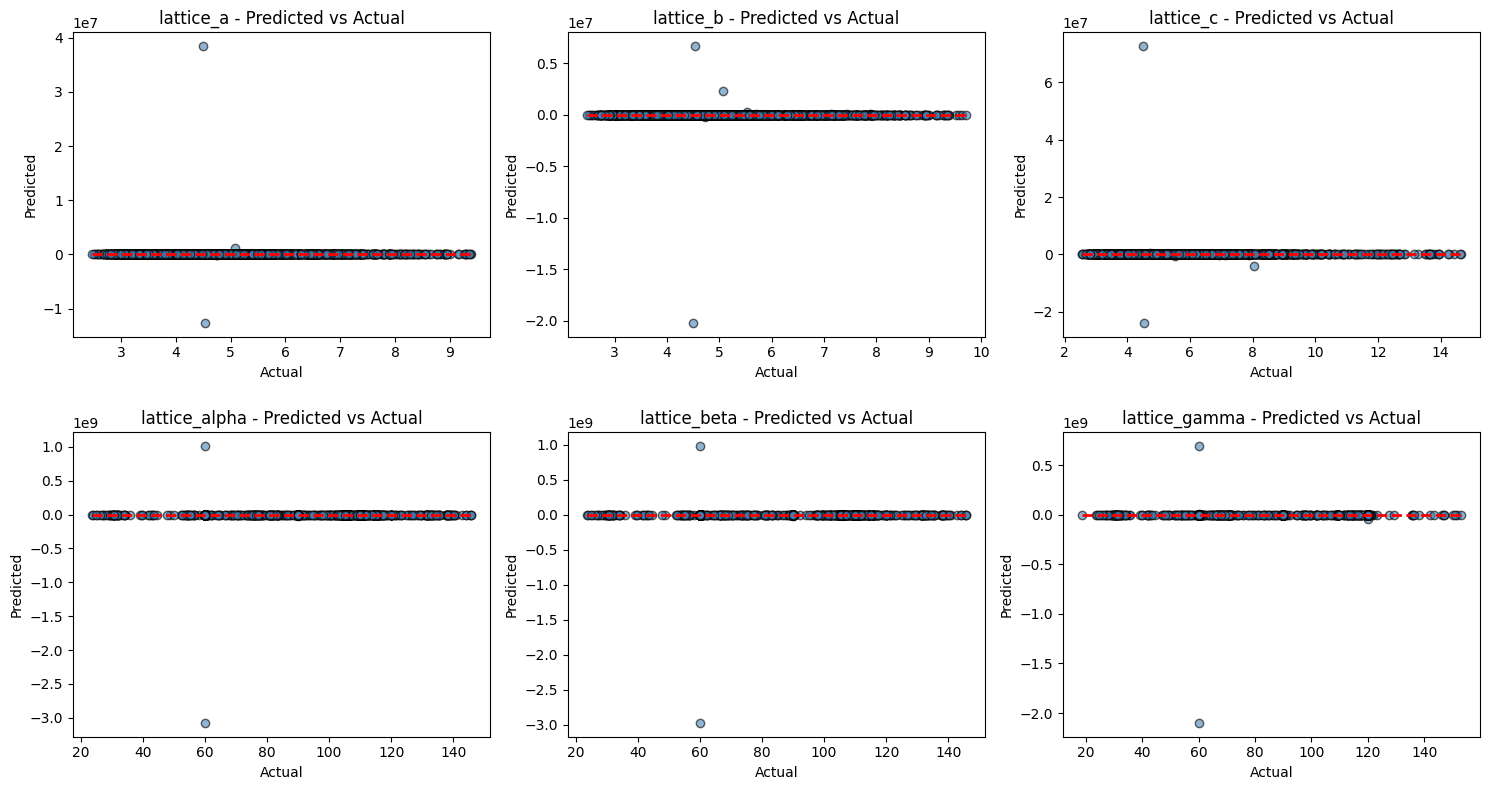

In [80]:
# Predict
y_pred = model.predict(X_test)
lattice_features = [
    "lattice_a", "lattice_b", "lattice_c",
    "lattice_alpha", "lattice_beta", "lattice_gamma"
]

# Evaluate
evaluate_multioutput_regression(Y_test.to_numpy(), y_pred, target_names=lattice_features)

# Plot
plot_multioutput_regression_results(Y_test.to_numpy(), y_pred, target_names=lattice_features)

In [64]:
print(X.dtypes)


nelements                      int64
band_gap                     float64
formation_energy_per_atom    float64
density                      float64
energy_above_hull            float64
volume                       float64
nsites                         int64
total_magnetization          float64
shear_modulus_final          float64
bulk_modulus_final           float64
dtype: object


In [65]:
# Check if all columns are numeric
print(X.dtypes)

# Look for extreme values
max_vals = X.abs().max()
print(max_vals.sort_values(ascending=False).head(10))

nelements                      int64
band_gap                     float64
formation_energy_per_atom    float64
density                      float64
energy_above_hull            float64
volume                       float64
nsites                         int64
total_magnetization          float64
shear_modulus_final          float64
bulk_modulus_final           float64
dtype: object
shear_modulus_final          1.129912e+14
bulk_modulus_final           9.397449e+11
volume                       1.831164e+03
nsites                       1.280000e+02
total_magnetization          1.231108e+02
density                      2.235969e+01
band_gap                     1.763770e+01
formation_energy_per_atom    4.687260e+00
energy_above_hull            4.687260e+00
nelements                    4.000000e+00
dtype: float64
